In [1]:
import multiprocessing
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def getDataForXGB (pir, location_training, location_status, emotion, 
                   n = 100000, nan_reference_col = 'bvp', 
                   fns = {'acc_x': [np.mean, np.std], 'acc_y': [np.mean, np.std], 'acc_z': [np.mean, np.std],
                          'bvp' : [np.mean, np.std], 'conductance': [np.mean, np.std],'heartrate': [np.mean, np.std],
                          'temperature': [np.mean, np.std]}, 
                   windows = ['1 h']): 
    """ Aggregate and prepare data for XGBRegressor
    
    Args:
        pir (int): the integer stands for the people in recovery
        localtion_training (str): the directory in which the PIR data is stored
        location_status (str): the directory in which the emotional satus of PIR is stored 
        emotion (str): the emotion we are trying to predict
        n (int): the number of samples to generate. Can be set to -1, which is the maximum. Defaults to 100k
        nan_reference_col (str, optional): the column with the maximum amount of data, used as a reference. 
            Defaults to 'bvp'.
        fns (Union[Dict[str, Callable], Iterable[Dict[str, Callable]]]): a dict of functions to apply to each column, 
            with keys as column names, or a list of dicts of functions separated for each window. Defaults to the
            mean and sd for each of the seven important features
        windows (Iterable[str]): a list of a window sizes in units that can be used for resample. Defaults to ['1 h']
    
    Returns: 
        pd.DataFrame: the PIR's data which is aggregated and is ready for the XGBRegressor
    """
    
    # read data for trainnig data and labels
    train = read_training_data(pir, location_training, add_craving = False, craving_length_hrs=1)
    status = pd.read_parquet(os.path.join(location_status, f'pir{pir}_e4_tot_32hz.pq'))
    status = status[status[emotion].first_valid_index():status[emotion].last_valid_index()]
    
    # joint two data set
    df = train.join(status, how='outer').sort_index()
    df = df[df[nan_reference_col].first_valid_index():df[nan_reference_col].last_valid_index()]
    df = df[df[emotion].first_valid_index():df[emotion].last_valid_index()]
    
    # select the columns we need and ffill NaN in the emotion column
    df_new = df[['acc_x','acc_y','acc_z','bvp','conductance', 'heartrate','temperature',emotion]]
    df_new[emotion] = df_new[emotion].ffill()
    
    
    # get the aggregated data using helper function
    agg_data = aggregate_training_set(df_new, n, fns, windows, window_overlaps = 1)
    
    return agg_data
      
    
    

def XGBRegressorForSurveyFast (df, emotion ,testRatio = 0.2, learning_rate = 0.1, max_depth = 5, colsample_bytree = 0.3,
                           subsample = 0.8):
    """predict whether the surveyee will be craving given the survey
    
    Args: 
        df (pd.DataFrame): the data set we need for the training and test data
        emotion (str): the emotion we are going to predict
        testRatio (float) : ratio of the test data in the whole dataset
        learning_rate (float): learning rate of XGB model, range [0, 1]. Defaults to 0.1
        max_depth (int): maximum depth of tree. Defaults to 5
        colsample_bytree (float): fraction of columns to be randomly sampled for each tree. Defaults to 0.3
        subsample (float): fraction of observations to be randomly sampled for each tree. Defaults to 0.8     
    """  
        
    # get the name of columns for features
    new_cols = [col for col in df.columns if col != emotion] + [emotion]
    df = df[new_cols]
    feature_columns = new_cols[:-1]

    # Isolate the x and y variables
    y = df.iloc[:, -1].values
    X = df.iloc[:, :-1].values
    
    #split dataset into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testRatio)
    
    # Create xgboost matrices
    Train = xgb.DMatrix(X_train, label = y_train, feature_names = feature_columns)
    Test = xgb.DMatrix(X_test, label = y_test, feature_names = feature_columns)
    
    finalParameters = {'learning_rate': learning_rate,
                       'max_depth': max_depth,
                       'colsample_bytree': colsample_bytree,
                       'subsample': subsample,
                       'eval_metric': "rmse",
                       'objective': "reg:squarederror"}
    
    finalModel = xgb.train(params = finalParameters,
                   dtrain = Train,
                   num_boost_round = 800,
                   evals = [(Test, "Yes")],
                   verbose_eval = 50)
    
    # Predictions on test dataset
    preds = finalModel.predict(Test)
    
    
    # show results
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("RMSE: %f" % (rmse))
    
    
    # plot feature importances
    xgb.plot_importance(finalModel, max_num_features = 10)
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()

In [2]:
df = pd.read_csv('agg_data.csv')
df = df.drop(['ts', '_window_end'], axis=1)
df.head()

,acc_x,acc_y,acc_z,bvp,conductance,heartrate,temperature,stressed,acc_x_1h__mean,acc_x_1h__std,...,acc_z_1h__mean,acc_z_1h__std,bvp_1h__mean,bvp_1h__std,conductance_1h__mean,conductance_1h__std,heartrate_1h__mean,heartrate_1h__std,temperature_1h__mean,temperature_1h__std
0,59.0,21.0,-21.0,-463.175,0.039721,109.23,34.75,3.0,44.143213,19.002027,...,-14.214931,25.811113,0.061996,188.057266,0.511844,0.735550,87.472742,13.624653,34.490249,0.665562
1,-57.0,21.0,-18.0,-169.770,0.683216,93.65,32.33,3.0,-17.675239,45.658263,...,7.577908,31.696079,-0.013041,175.206632,0.712755,1.313117,90.409003,14.367658,32.513215,1.158329
2,-53.0,18.0,31.0,91.250,0.088412,128.02,32.05,3.0,-17.675239,45.658263,...,7.577908,31.696079,-0.013041,175.206632,0.712755,1.313117,90.409003,14.367658,32.513215,1.158329
3,-23.0,59.0,18.0,113.700,0.151197,85.67,31.91,7.0,-17.675239,45.658263,...,7.577908,31.696079,-0.013041,175.206632,0.712755,1.313117,90.409003,14.367658,32.513215,1.158329
4,-57.0,-17.0,26.0,88.600,0.165292,69.27,31.17,7.0,-17.675239,45.658263,...,7.577908,31.696079,-0.013041,175.206632,0.712755,1.313117,90.409003,14.367658,32.513215,1.158329


[0]	Yes-rmse:4.82806
[50]	Yes-rmse:1.89547
[100]	Yes-rmse:1.65286
[150]	Yes-rmse:1.46458
[200]	Yes-rmse:1.31633
[250]	Yes-rmse:1.21862
[300]	Yes-rmse:1.13628
[350]	Yes-rmse:1.07555
[400]	Yes-rmse:1.02529
[450]	Yes-rmse:0.98395
[500]	Yes-rmse:0.95795
[550]	Yes-rmse:0.93342
[600]	Yes-rmse:0.91019
[650]	Yes-rmse:0.89674
[700]	Yes-rmse:0.88360
[750]	Yes-rmse:0.87319
[799]	Yes-rmse:0.86446
RMSE: 0.864464


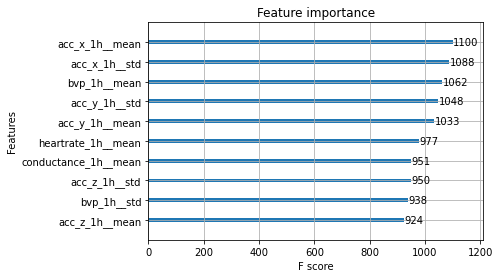

In [3]:
XGBRegressorForSurveyFast(df, "stressed" ,testRatio = 0.2)